# **Ministry Budget: Data Analysis**

A partir de una base de datos acerca de "Presupuesto y Ejecución de Gastos 2023" buscamos predecir la variable MTO_PIA que representa el "Monto asignado de Presupuesto Institucional de Apertura". 

La idea es elegir aquellas variables que afecten a la predicción de este presupuesto, para ello realizamos la limpieza de los datos de entrenamiento y posteriormente el análisis exploratorio de los datos (AED) que permite preparar aquellas variables para implementarlas en el modelo de regresión.

---
## **Libraries**

In [111]:
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;

from subprocess import check_output;
from sklearn.preprocessing import LabelEncoder;

---

## **Dataset**

In [112]:
selected_data_columns = [
    'PROGRAMA_PPTAL',
    'ACT_OBRA_ACCINV',
    'GRUPO_FN',
    'META',
    'AVAN_FISICO_SEM',
    'UBIGEO',
    'SUBGENERICA_DET',
    'MTO_PIA',
];

train_data = pd.read_csv('./db/train.csv')
train_data = train_data[selected_data_columns]
train_data = train_data.dropna()

In [113]:
train_data.info()
train_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PROGRAMA_PPTAL   1464 non-null   object
 1   ACT_OBRA_ACCINV  1464 non-null   object
 2   GRUPO_FN         1464 non-null   object
 3   META             1464 non-null   int64 
 4   AVAN_FISICO_SEM  1464 non-null   int64 
 5   UBIGEO           1464 non-null   int64 
 6   SUBGENERICA_DET  1464 non-null   object
 7   MTO_PIA          1464 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 91.6+ KB


,PROGRAMA_PPTAL,ACT_OBRA_ACCINV,GRUPO_FN,META,AVAN_FISICO_SEM,UBIGEO,SUBGENERICA_DET,MTO_PIA
0,9001.ACCIONES CENTRALES,5000003.GESTION ADMINISTRATIVA,0008.ASESORAMIENTO Y APOYO,6,6,50199,"6.SERVICIOS ADMINISTRATIVOS, FINANCIEROS Y DE ...",0
1,9001.ACCIONES CENTRALES,5000003.GESTION ADMINISTRATIVA,0008.ASESORAMIENTO Y APOYO,20,6,230199,1.VIAJES,805
2,9002.ASIGNACIONES PRESUPUESTARIAS QUE NO RESUL...,5002358.GESTION DE LAS PRESTACIONES SOCIALES,0114.DESARROLLO DE CAPACIDADES SOCIALES Y ECON...,4,16,10199,8.CONTRATO ADMINISTRATIVO DE SERVICIOS,0
3,9001.ACCIONES CENTRALES,5000003.GESTION ADMINISTRATIVA,0008.ASESORAMIENTO Y APOYO,1,6,150101,"6.SERVICIOS ADMINISTRATIVOS, FINANCIEROS Y DE ...",0
4,9001.ACCIONES CENTRALES,5000003.GESTION ADMINISTRATIVA,0008.ASESORAMIENTO Y APOYO,7,6,50699,7.SERVICIOS PROFESIONALES Y TECNICOS,8816


---
## **Análisis exploratorio de Datos**

El primer paso será convertir aquellas variables categóricas a numéricas. En este caso, la base de datos tiene tanto categóricas nominales como ordinales, por lo que el tratamiento de datos debe ser distinto, un ejemplo son DEPARTAMENTO y ESPECIFICA respectivamente, no obstante se decidió utilizar la función **label encoder** que se encarga de asignar un número a cada categoría para después analizarlo con ese identificador.

In [114]:
def get_categorical_label (dataframe):
  labelEncoder = LabelEncoder()

  for each_column in dataframe.columns:
    if dataframe[each_column].dtype == 'object':
      train_data[each_column] = labelEncoder.fit_transform(train_data[each_column])

get_categorical_label(train_data)

In [115]:
train_data.info()
train_data.head(5)
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   PROGRAMA_PPTAL   1464 non-null   int32
 1   ACT_OBRA_ACCINV  1464 non-null   int32
 2   GRUPO_FN         1464 non-null   int32
 3   META             1464 non-null   int64
 4   AVAN_FISICO_SEM  1464 non-null   int64
 5   UBIGEO           1464 non-null   int64
 6   SUBGENERICA_DET  1464 non-null   int32
 7   MTO_PIA          1464 non-null   int64
dtypes: int32(4), int64(4)
memory usage: 68.8 KB


,PROGRAMA_PPTAL,ACT_OBRA_ACCINV,GRUPO_FN,META,AVAN_FISICO_SEM,UBIGEO,SUBGENERICA_DET,MTO_PIA
count,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1.464000e+03
mean,1.557377,4.267077,3.679645,12.462432,874.536202,126105.652322,14.434426,4.745334e+04
std,0.503698,2.004877,1.513384,7.395105,7136.279030,69018.461602,5.917276,1.844846e+05
min,0.000000,0.000000,0.000000,1.000000,0.000000,10199.000000,0.000000,0.000000e+00
25%,1.000000,2.000000,2.000000,6.000000,4.000000,60199.000000,9.000000,1.330000e+02
50%,2.000000,6.000000,5.000000,12.000000,6.000000,140199.000000,15.000000,2.316500e+03
75%,2.000000,6.000000,5.000000,18.000000,16.000000,180199.000000,20.000000,1.742675e+04
max,2.000000,9.000000,5.000000,27.000000,61303.000000,250199.000000,23.000000,2.816373e+06


Ahora, es importante considerar qué tan correlacionadas está nuestra variable independiente y dependiente (MTO_PIA). Para ello podemos aprovechar la funcionalidad que nos brinda pandas.

In [116]:
print(train_data.corr()['MTO_PIA'])

PROGRAMA_PPTAL     0.068939
ACT_OBRA_ACCINV    0.062121
GRUPO_FN           0.062056
META              -0.047390
AVAN_FISICO_SEM    0.027541
UBIGEO            -0.017282
SUBGENERICA_DET    0.143861
MTO_PIA            1.000000
Name: MTO_PIA, dtype: float64


En este caso podemos observar que según la correlación ofrecida por la función de python, no existe una correlación directa entre las variables. En pocas palabras, para cada variable seleccionada no existe una constante de cambio tal que mantenga la proporción, pues nuestro valores tienden a 0, donde la correlación es mínima. Esto es un claro ejemplo que nuestro modelo tendrá que ser no-lineal y para adaptar la forma, multivariable (polinomio).

<Axes: >

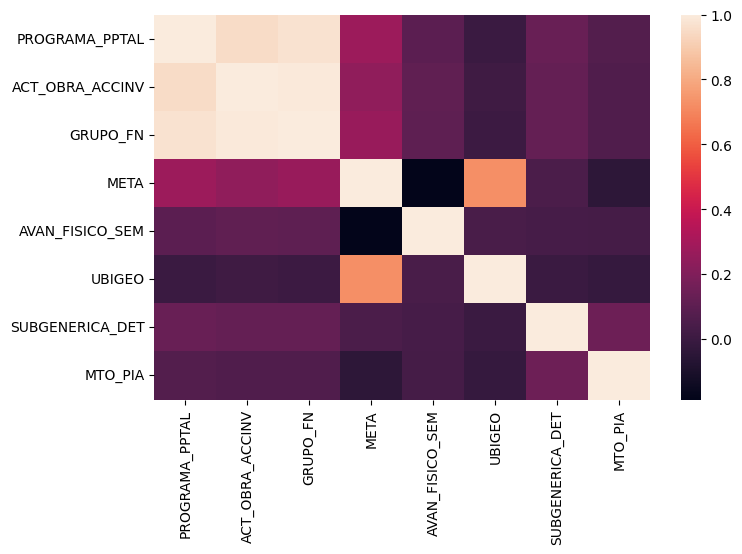

In [117]:
correlation_matrix = train_data.corr()
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(correlation_matrix)

En el ejemplo superior es posible notar una información valiosa, para distintos programas existe una categoría presupuestal distinta, esto indica que va variar el MTO_PIA dependiendo aquel valor, es así entonces que es un criterio del gasto presupuestal.

In [118]:
# Calculate mean of 'MTO_PIA' for each group and sort by mean
mean_df = train_data.groupby('GRUPO_FN', as_index=False)['MTO_PIA'].mean().sort_values('MTO_PIA')

Con el promedio mostrado para cada único grupo funcional, podemos notar que para el grupo 4 tenemos un mínimo promedio, mientras que para el código 1 tenemos una alta prioridad, pues tiene el promedio de MTO_PIA más alto. 

Por otro lado la mediana tiene a 10,000 como valor que divide el conjunto de datos en dos partes iguales, la mitad de datos cae por debajo y la otra mitad por encima.

In [119]:
train_data.to_csv('./db/trainDataModified.csv', index=False);